
# HackerEarth Deep Learning Challenge: 'Tis STILL the season to be jolly

You work for a social media platform. Your task is to create a solution using deep learning to discern whether a post is holiday-related in an effort to better monetize the platform.

Task-
You are given the following six categories. You are required to classify the images in the dataset based on these categories.

    Miscellaneous
    Christmas_Tree
    Jacket
    Candle
    Airplane
    Snowman


# Loading necessary libraries

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

# Datset Analysis

In [28]:
df_train = pd.read_csv('../input/hackereath-holiday-season-deep-learning-contest/dataset/train.csv')
df_train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [29]:
df_train['Class'].value_counts()

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

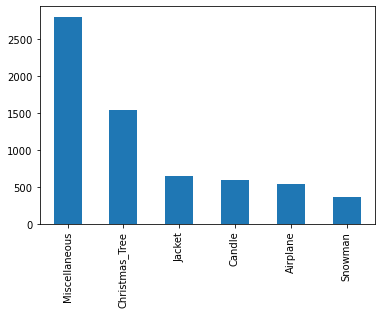

In [30]:
df_train['Class'].value_counts().plot(kind='bar')

# Data Augmentation of the Training Set
To balance all the number of instances for each class in the dataset

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=True,
         width_shift_range=0.2,
         height_shift_range=0.2)

batch_size = 128
target_size = (299,299)

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="../input/hackereath-holiday-season-deep-learning-contest/dataset/train",
                                            x_col="Image",
                                            y_col="Class",
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=target_size)

Found 6469 validated image filenames belonging to 6 classes.


In [45]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [46]:
augmented_images = [train_generator[0][0][0] for i in range(5)]


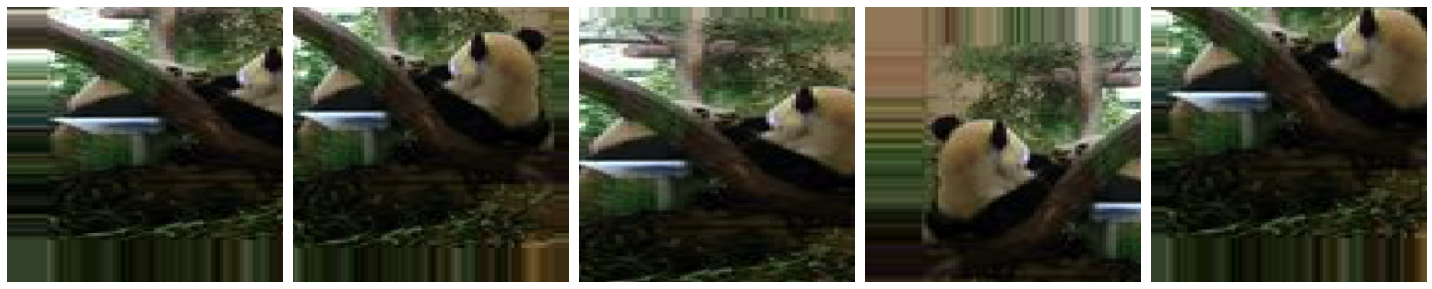

In [47]:
plotImages(augmented_images)

# Loading pre-trained models
NOTE: Although Inception is a pretty dense model, it will always give a good prediction

In [48]:
model = tf.keras.applications.InceptionResNetV2(include_top=True,weights="imagenet")

In [49]:
num_classes = 6
# Taking the input to the last layer [-1], i.e. output of layer[-2]
x = model.layers[-2].output
# Connecting that output to a fully connected layer for classification
fc = Dense(1024,activation='relu')(x)
fc = Dense(512,activation='relu')(fc)
fc = Dense(256,activation='relu')(fc)
fc = Dense(num_classes,activation='softmax')(fc)

In [50]:
model1 = Model(inputs=model.input,outputs=fc)
model1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 149, 149, 32) 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 149, 149, 32) 0           batch_normalization_406[0][0]    
_______________________________________________________________________________________

conv2d_576 (Conv2D)             (None, 8, 8, 256)    172032      activation_575[0][0]             
__________________________________________________________________________________________________
batch_normalization_573 (BatchN (None, 8, 8, 192)    576         conv2d_573[0][0]                 
__________________________________________________________________________________________________
batch_normalization_576 (BatchN (None, 8, 8, 256)    768         conv2d_576[0][0]                 
__________________________________________________________________________________________________
activation_573 (Activation)     (None, 8, 8, 192)    0           batch_normalization_573[0][0]    
__________________________________________________________________________________________________
activation_576 (Activation)     (None, 8, 8, 256)    0           batch_normalization_576[0][0]    
__________________________________________________________________________________________________
block8_2_m

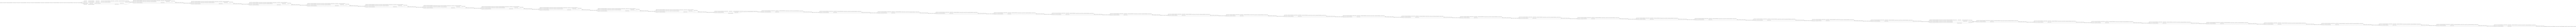

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png', rankdir='LR')

In [52]:
plot_model(model1, to_file='model.png')

In [53]:
# You don't need to re-train all the layers of the model, just t
# freezing all the layers
# Training only the last 16 layers
for layer in model1.layers[:-16]:
    print(layer)
    layer.trainable = False

# Model Compilation

In [54]:
model1.compile(optimizer='adam',loss ="categorical_crossentropy",metrics=["accuracy"])

# Model Training

In [55]:
history = model1.fit_generator(train_generator, epochs = 4)

Epoch 1/4
51/51 [==============================] - 153s 3s/step - loss: 0.5415 - accuracy: 0.8106
Epoch 2/4
51/51 [==============================] - 160s 3s/step - loss: 0.2861 - accuracy: 0.8981
Epoch 3/4
51/51 [==============================] - 157s 3s/step - loss: 0.2331 - accuracy: 0.9159
Epoch 4/4
51/51 [==============================] - 160s 3s/step - loss: 0.2088 - accuracy: 0.9236


### Visualization of the Metrics calculated

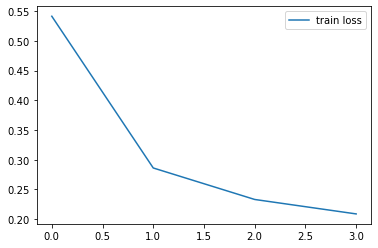

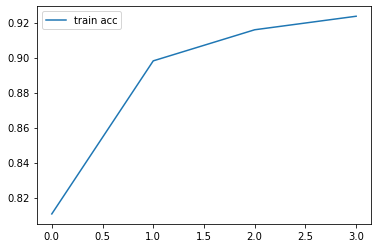

<Figure size 432x288 with 0 Axes>

In [60]:
# Loss
plt.plot(history.history['loss'], label='train loss')
plt.legend()
plt.show()
plt.savefig('Loss_Curve')

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('Accuracy_Curve')

In [61]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Holiday_Classifier.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/saved_models/Holiday_Classifier.h5 


## Predictions

In [62]:
classes = train_generator.class_indices

In [63]:
classes.items()

dict_items([('Airplane', 0), ('Candle', 1), ('Christmas_Tree', 2), ('Jacket', 3), ('Miscellaneous', 4), ('Snowman', 5)])

In [64]:
classes = dict((v,k) for k,v in classes.items())
classes = [classes[k] for k in classes]

In [65]:
# Using the model to predict the outputs in the test set
Image = []
prediction = []

for i, file in enumerate(os.listdir('../input/hackereath-holiday-season-deep-learning-contest/dataset/test/')):
    Image.append(file)
    file = '../input/hackereath-holiday-season-deep-learning-contest/dataset/test/' + file

    img = image.load_img(file, target_size=(299,299,3)) 
    img = image.img_to_array(img)
    img = img/255
    pred = model1.predict(img.reshape(1,299,299,3))

    prediction.append(classes[np.argmax(pred[0])])

# Submission File Generation

In [66]:
data=pd.DataFrame((zip(Image, prediction)),columns=['Image','Class'])
data.head()

,Image,Class
0,image7761.jpg,Airplane
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree


In [67]:
data.to_csv('submission1.csv',index=False)